In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join, exists
from sys import stdout

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import Sequence
from keras.utils.vis_utils import plot_model

import imgaug as ia
import imgaug.augmenters as iaa

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES, FILE_DATASET
from custom_losses import wing_loss
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import eye_localization_accuracy, eye_localization_fvc
from icao_dataset import ICAODataset
from data_structures import Point
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)
FILE_BEST_MODEL = join(PATH_TO_ROOT, 'models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5')

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_AUTOENCODER_SAMPLES)
print(FILE_BEST_MODEL)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces_eyes/dataset_dlib.pkl
../../data/unsupervised_supervised_samples.pkl
../../models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
if exists(FILE_DATASET):
    print("Dataset found. Loading...")
    dataset = pkl.load(open(FILE_DATASET, "rb"))
else:
    print("Generating dataset...")
    dataset = ICAODataset()
    dataset.load(FOLDER_IMAGES, FOLDER_MRKS, output_size=(160, 160))
    pkl.dump(dataset, open(FILE_DATASET, "wb"))

Dataset found. Loading...


In [6]:
x = np.array(dataset.images)
mrks = np.array(dataset.mrks)
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(4999, 160, 160, 3) float32
(4999, 23) int32
(4999, 4) float64
4999


In [7]:
y_eyes.min(), y_eyes.max()

(51.5, 104.5)

In [8]:
# x /= 255
# y_eyes /= x.shape[1]

In [9]:
# x.min(), x.max()

In [10]:
# y_eyes.min(), y_eyes.max()

#### divide train and test

In [11]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train_reqs, x_val_idx, y_val_reqs = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1),
    y_reqs,
    test_size=TEST_SIZE
)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

y_train_eyes = y_eyes[x_train_idx]
y_val_eyes = y_eyes[x_val_idx]

print(x_train.shape, y_train_reqs.shape, y_train_eyes.shape)
print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(4490, 160, 160, 3) (4490, 23) (4490, 4)
(509, 160, 160, 3) (509, 23) (509, 4)


In [12]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# Data Augmentation 

In [13]:
class ImageLandmarkGenerator(Sequence):
    """ImageDataGenerator + ImgAug"""
    def __init__(self, x, y_reqs, y_eyes, batch_size=32, shuffle=True, **affine_kwargs):
        self.x = x
        self.y_reqs = y_reqs
        self.y_eyes = y_eyes
        self.batch_size = min(batch_size, x.shape[0])
        self.shuffle = shuffle
        self.aug = iaa.Affine(**affine_kwargs)
        self.indexes = np.arange(self.x.shape[0])
        if shuffle:# Data Augmentation 
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        return self.x.shape[0] // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = self.x[indexes]
        reqs = self.y_reqs[indexes]
        landmarks = self.y_eyes[indexes]
        shape = self.x.shape[1:]
        
        keypoints = [ia.KeypointsOnImage.from_xy_array(landmark.reshape(-1, 2), shape=shape) for landmark in landmarks]
        images_aug, keypoints_aug = self.aug(images=images, keypoints=keypoints)
        landmarks_aug = np.array([kp.to_xy_array().flatten() for kp in keypoints_aug])

        return images_aug / 255, [images_aug / 255, reqs, landmarks_aug / x.shape[1]]

(7, 160, 160, 3) (7, 4)


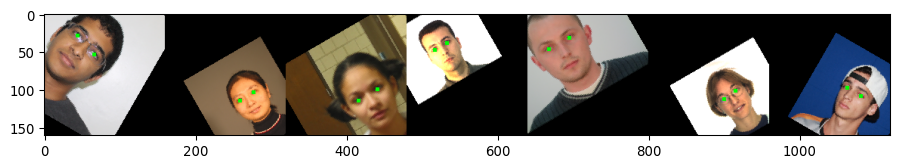

In [38]:
affine_params = dict(
    translate_percent=[-0.2, 0.2],
    rotate=[-30, 30],
    scale=[0.8, 1.2],
    order=0,
)

gen = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=7, **affine_params)
_, (images, _, landmarks) = gen.__getitem__(0)
print(images.shape, landmarks.shape)

draw_list = []
for im, landmark in zip(images, landmarks):
    kp = ia.KeypointsOnImage.from_xy_array((landmark * x_train.shape[1]).reshape(-1, 2), shape=im.shape)
    draw_list.append(kp.draw_on_image((im * 255).astype(np.uint8)[:, :, ::-1], size=5))

ia.imshow(np.hstack(draw_list))

# Model Training 

In [15]:
custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc
}

best_model = load_model(FILE_BEST_MODEL, custom_objects=custom_objects)

for layer in best_model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


In [16]:
def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate, name=drop_name)(prev_input)
    out = Dense(units, activation=activation, name=dense_name)(prev_input)
    return out

In [17]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_EYES = y_train_eyes.shape[1]

avg_pool = best_model.get_layer("global_average_pooling2d_1").output

dense_3 = dense_layer(3, avg_pool, 64)
dense_4 = dense_layer(4, dense_3, 64)
regress = Dense(units=N_EYES, activation='sigmoid', name='output_eyes')(dense_4)

model = Model(
    inputs=best_model.inputs,
    outputs=[
        best_model.get_layer("decoded").output,
        best_model.get_layer("outputs").output,
        regress
    ],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

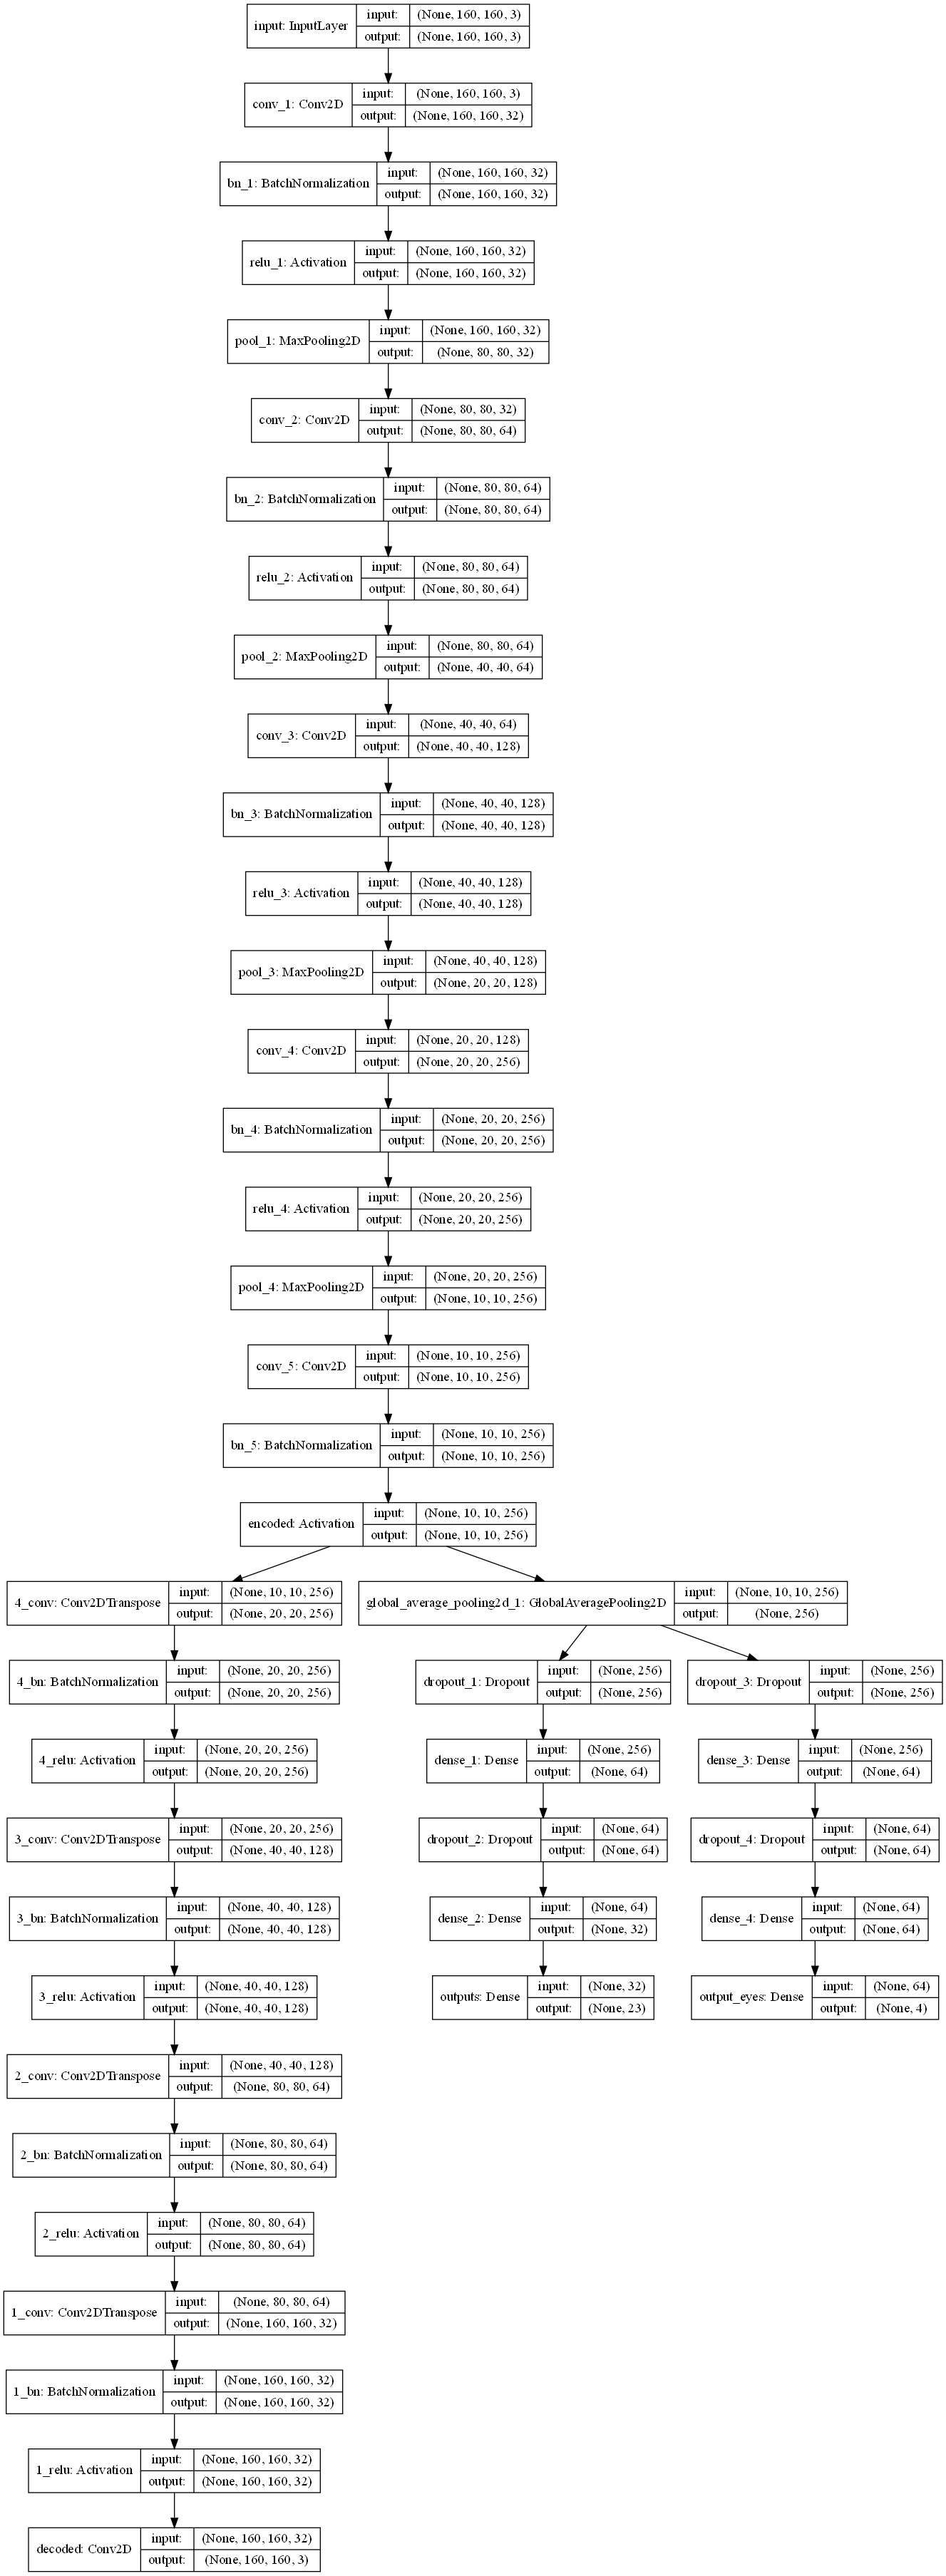

In [18]:
plot_model(model, show_shapes=True)

Epoch 1/500
100/100 [==============================] - 20s 200ms/step - loss: 1.3704 - decoded_loss: 0.0159 - outputs_loss: 0.5799 - output_eyes_loss: 1.3704 - outputs_accuracy: 0.8101 - outputs_precision: 0.8799 - outputs_recall: 0.8904 - outputs_f1: 0.8850 - outputs_fbeta: 0.8861 - outputs_specificity: 0.4423 - outputs_negative_predictive_value: 0.4675 - outputs_matthews_correlation_coefficient: 0.3396 - output_eyes_mae: 0.1212 - output_eyes_mse: 0.0213 - output_eyes_eye_localization_accuracy: 6.2500e-04 - val_loss: 0.7102 - val_decoded_loss: 0.0095 - val_outputs_loss: 0.9021 - val_output_eyes_loss: 0.7380 - val_outputs_accuracy: 0.7493 - val_outputs_precision: 0.8772 - val_outputs_recall: 0.8083 - val_outputs_f1: 0.8412 - val_outputs_fbeta: 0.8193 - val_outputs_specificity: 0.4739 - val_outputs_negative_predictive_value: 0.3481 - val_outputs_matthews_correlation_coefficient: 0.2521 - val_output_eyes_mae: 0.0649 - val_output_eyes_mse: 0.0077 - val_output_eyes_eye_localization_accurac

100/100 [==============================] - 15s 151ms/step - loss: 0.4885 - decoded_loss: 0.0161 - outputs_loss: 0.5736 - output_eyes_loss: 0.4885 - outputs_accuracy: 0.8102 - outputs_precision: 0.8811 - outputs_recall: 0.8893 - outputs_f1: 0.8850 - outputs_fbeta: 0.8853 - outputs_specificity: 0.4440 - outputs_negative_predictive_value: 0.4646 - outputs_matthews_correlation_coefficient: 0.3390 - output_eyes_mae: 0.0416 - output_eyes_mse: 0.0034 - output_eyes_eye_localization_accuracy: 0.0166 - val_loss: 0.5566 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9456 - val_output_eyes_loss: 0.5437 - val_outputs_accuracy: 0.7489 - val_outputs_precision: 0.8784 - val_outputs_recall: 0.8071 - val_outputs_f1: 0.8409 - val_outputs_fbeta: 0.8181 - val_outputs_specificity: 0.4807 - val_outputs_negative_predictive_value: 0.3503 - val_outputs_matthews_correlation_coefficient: 0.2562 - val_output_eyes_mae: 0.0473 - val_output_eyes_mse: 0.0046 - val_output_eyes_eye_localization_accuracy: 0.0083

Epoch

100/100 [==============================] - 14s 145ms/step - loss: 0.3070 - decoded_loss: 0.0161 - outputs_loss: 0.5773 - output_eyes_loss: 0.3070 - outputs_accuracy: 0.8122 - outputs_precision: 0.8821 - outputs_recall: 0.8906 - outputs_f1: 0.8862 - outputs_fbeta: 0.8867 - outputs_specificity: 0.4516 - outputs_negative_predictive_value: 0.4722 - outputs_matthews_correlation_coefficient: 0.3479 - output_eyes_mae: 0.0257 - output_eyes_mse: 0.0021 - output_eyes_eye_localization_accuracy: 0.0609 - val_loss: 0.4120 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9663 - val_output_eyes_loss: 0.4438 - val_outputs_accuracy: 0.7520 - val_outputs_precision: 0.8812 - val_outputs_recall: 0.8084 - val_outputs_f1: 0.8431 - val_outputs_fbeta: 0.8205 - val_outputs_specificity: 0.4869 - val_outputs_negative_predictive_value: 0.3505 - val_outputs_matthews_correlation_coefficient: 0.2615 - val_output_eyes_mae: 0.0389 - val_output_eyes_mse: 0.0050 - val_output_eyes_eye_localization_accuracy: 0.0354

Epoch

100/100 [==============================] - 15s 152ms/step - loss: 0.2478 - decoded_loss: 0.0160 - outputs_loss: 0.5768 - output_eyes_loss: 0.2478 - outputs_accuracy: 0.8136 - outputs_precision: 0.8827 - outputs_recall: 0.8920 - outputs_f1: 0.8872 - outputs_fbeta: 0.8878 - outputs_specificity: 0.4513 - outputs_negative_predictive_value: 0.4749 - outputs_matthews_correlation_coefficient: 0.3500 - output_eyes_mae: 0.0207 - output_eyes_mse: 0.0012 - output_eyes_eye_localization_accuracy: 0.1169 - val_loss: 0.5349 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9432 - val_output_eyes_loss: 0.4413 - val_outputs_accuracy: 0.7452 - val_outputs_precision: 0.8763 - val_outputs_recall: 0.8040 - val_outputs_f1: 0.8383 - val_outputs_fbeta: 0.8150 - val_outputs_specificity: 0.4760 - val_outputs_negative_predictive_value: 0.3440 - val_outputs_matthews_correlation_coefficient: 0.2481 - val_output_eyes_mae: 0.0389 - val_output_eyes_mse: 0.0063 - val_output_eyes_eye_localization_accuracy: 0.0479

Epoch

100/100 [==============================] - 15s 145ms/step - loss: 0.2412 - decoded_loss: 0.0166 - outputs_loss: 0.5942 - output_eyes_loss: 0.2412 - outputs_accuracy: 0.8106 - outputs_precision: 0.8828 - outputs_recall: 0.8879 - outputs_f1: 0.8852 - outputs_fbeta: 0.8843 - outputs_specificity: 0.4510 - outputs_negative_predictive_value: 0.4635 - outputs_matthews_correlation_coefficient: 0.3423 - output_eyes_mae: 0.0205 - output_eyes_mse: 0.0013 - output_eyes_eye_localization_accuracy: 0.1419 - val_loss: 0.2864 - val_decoded_loss: 0.0098 - val_outputs_loss: 0.9728 - val_output_eyes_loss: 0.4165 - val_outputs_accuracy: 0.7452 - val_outputs_precision: 0.8779 - val_outputs_recall: 0.8025 - val_outputs_f1: 0.8382 - val_outputs_fbeta: 0.8142 - val_outputs_specificity: 0.4786 - val_outputs_negative_predictive_value: 0.3414 - val_outputs_matthews_correlation_coefficient: 0.2480 - val_output_eyes_mae: 0.0393 - val_output_eyes_mse: 0.0065 - val_output_eyes_eye_localization_accuracy: 0.0688

Epoch

100/100 [==============================] - 15s 146ms/step - loss: 0.2314 - decoded_loss: 0.0162 - outputs_loss: 0.5895 - output_eyes_loss: 0.2314 - outputs_accuracy: 0.8119 - outputs_precision: 0.8822 - outputs_recall: 0.8903 - outputs_f1: 0.8861 - outputs_fbeta: 0.8863 - outputs_specificity: 0.4491 - outputs_negative_predictive_value: 0.4689 - outputs_matthews_correlation_coefficient: 0.3448 - output_eyes_mae: 0.0196 - output_eyes_mse: 0.0013 - output_eyes_eye_localization_accuracy: 0.1500 - val_loss: 0.5620 - val_decoded_loss: 0.0098 - val_outputs_loss: 0.9682 - val_output_eyes_loss: 0.4291 - val_outputs_accuracy: 0.7468 - val_outputs_precision: 0.8772 - val_outputs_recall: 0.8056 - val_outputs_f1: 0.8397 - val_outputs_fbeta: 0.8170 - val_outputs_specificity: 0.4733 - val_outputs_negative_predictive_value: 0.3429 - val_outputs_matthews_correlation_coefficient: 0.2475 - val_output_eyes_mae: 0.0393 - val_output_eyes_mse: 0.0070 - val_output_eyes_eye_localization_accuracy: 0.0958

Epoch

100/100 [==============================] - 15s 155ms/step - loss: 0.2299 - decoded_loss: 0.0162 - outputs_loss: 0.5928 - output_eyes_loss: 0.2299 - outputs_accuracy: 0.8100 - outputs_precision: 0.8794 - outputs_recall: 0.8907 - outputs_f1: 0.8848 - outputs_fbeta: 0.8863 - outputs_specificity: 0.4425 - outputs_negative_predictive_value: 0.4700 - outputs_matthews_correlation_coefficient: 0.3408 - output_eyes_mae: 0.0193 - output_eyes_mse: 0.0012 - output_eyes_eye_localization_accuracy: 0.1478 - val_loss: 0.5734 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9564 - val_output_eyes_loss: 0.4088 - val_outputs_accuracy: 0.7458 - val_outputs_precision: 0.8770 - val_outputs_recall: 0.8040 - val_outputs_f1: 0.8388 - val_outputs_fbeta: 0.8163 - val_outputs_specificity: 0.4736 - val_outputs_negative_predictive_value: 0.3414 - val_outputs_matthews_correlation_coefficient: 0.2460 - val_output_eyes_mae: 0.0374 - val_output_eyes_mse: 0.0065 - val_output_eyes_eye_localization_accuracy: 0.0938

Epoch


Epoch 00050: val_output_eyes_eye_localization_accuracy did not improve from 0.12083
Epoch 51/500
100/100 [==============================] - 15s 153ms/step - loss: 0.2371 - decoded_loss: 0.0163 - outputs_loss: 0.5787 - output_eyes_loss: 0.2371 - outputs_accuracy: 0.8130 - outputs_precision: 0.8821 - outputs_recall: 0.8919 - outputs_f1: 0.8868 - outputs_fbeta: 0.8877 - outputs_specificity: 0.4496 - outputs_negative_predictive_value: 0.4729 - outputs_matthews_correlation_coefficient: 0.3477 - output_eyes_mae: 0.0203 - output_eyes_mse: 0.0016 - output_eyes_eye_localization_accuracy: 0.1481 - val_loss: 0.5153 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9395 - val_output_eyes_loss: 0.4389 - val_outputs_accuracy: 0.7517 - val_outputs_precision: 0.8766 - val_outputs_recall: 0.8123 - val_outputs_f1: 0.8432 - val_outputs_fbeta: 0.8225 - val_outputs_specificity: 0.4714 - val_outputs_negative_predictive_value: 0.3504 - val_outputs_matthews_correlation_coefficient: 0.2536 - val_output_eyes_ma

100/100 [==============================] - 15s 147ms/step - loss: 0.2215 - decoded_loss: 0.0162 - outputs_loss: 0.5881 - output_eyes_loss: 0.2215 - outputs_accuracy: 0.8128 - outputs_precision: 0.8837 - outputs_recall: 0.8904 - outputs_f1: 0.8869 - outputs_fbeta: 0.8867 - outputs_specificity: 0.4477 - outputs_negative_predictive_value: 0.4644 - outputs_matthews_correlation_coefficient: 0.3428 - output_eyes_mae: 0.0186 - output_eyes_mse: 0.0011 - output_eyes_eye_localization_accuracy: 0.1731 - val_loss: 0.3679 - val_decoded_loss: 0.0096 - val_outputs_loss: 0.9262 - val_output_eyes_loss: 0.3728 - val_outputs_accuracy: 0.7505 - val_outputs_precision: 0.8750 - val_outputs_recall: 0.8127 - val_outputs_f1: 0.8425 - val_outputs_fbeta: 0.8225 - val_outputs_specificity: 0.4658 - val_outputs_negative_predictive_value: 0.3495 - val_outputs_matthews_correlation_coefficient: 0.2497 - val_output_eyes_mae: 0.0354 - val_output_eyes_mse: 0.0053 - val_output_eyes_eye_localization_accuracy: 0.1063

Epoch


Epoch 00065: val_output_eyes_eye_localization_accuracy did not improve from 0.12708
Epoch 66/500
100/100 [==============================] - 15s 148ms/step - loss: 0.2201 - decoded_loss: 0.0163 - outputs_loss: 0.5826 - output_eyes_loss: 0.2201 - outputs_accuracy: 0.8106 - outputs_precision: 0.8803 - outputs_recall: 0.8907 - outputs_f1: 0.8853 - outputs_fbeta: 0.8863 - outputs_specificity: 0.4414 - outputs_negative_predictive_value: 0.4666 - outputs_matthews_correlation_coefficient: 0.3391 - output_eyes_mae: 0.0186 - output_eyes_mse: 0.0013 - output_eyes_eye_localization_accuracy: 0.1762 - val_loss: 0.3907 - val_decoded_loss: 0.0098 - val_outputs_loss: 0.9582 - val_output_eyes_loss: 0.3499 - val_outputs_accuracy: 0.7507 - val_outputs_precision: 0.8808 - val_outputs_recall: 0.8074 - val_outputs_f1: 0.8424 - val_outputs_fbeta: 0.8187 - val_outputs_specificity: 0.4815 - val_outputs_negative_predictive_value: 0.3467 - val_outputs_matthews_correlation_coefficient: 0.2563 - val_output_eyes_ma

100/100 [==============================] - 15s 148ms/step - loss: 0.2245 - decoded_loss: 0.0161 - outputs_loss: 0.5874 - output_eyes_loss: 0.2245 - outputs_accuracy: 0.8130 - outputs_precision: 0.8815 - outputs_recall: 0.8925 - outputs_f1: 0.8869 - outputs_fbeta: 0.8880 - outputs_specificity: 0.4466 - outputs_negative_predictive_value: 0.4737 - outputs_matthews_correlation_coefficient: 0.3467 - output_eyes_mae: 0.0191 - output_eyes_mse: 0.0014 - output_eyes_eye_localization_accuracy: 0.1937 - val_loss: 0.2412 - val_decoded_loss: 0.0096 - val_outputs_loss: 0.9287 - val_output_eyes_loss: 0.2878 - val_outputs_accuracy: 0.7515 - val_outputs_precision: 0.8805 - val_outputs_recall: 0.8080 - val_outputs_f1: 0.8426 - val_outputs_fbeta: 0.8199 - val_outputs_specificity: 0.4891 - val_outputs_negative_predictive_value: 0.3528 - val_outputs_matthews_correlation_coefficient: 0.2631 - val_output_eyes_mae: 0.0265 - val_output_eyes_mse: 0.0032 - val_output_eyes_eye_localization_accuracy: 0.0854

Epoch

100/100 [==============================] - 15s 148ms/step - loss: 0.2102 - decoded_loss: 0.0162 - outputs_loss: 0.5794 - output_eyes_loss: 0.2102 - outputs_accuracy: 0.8124 - outputs_precision: 0.8840 - outputs_recall: 0.8889 - outputs_f1: 0.8863 - outputs_fbeta: 0.8855 - outputs_specificity: 0.4577 - outputs_negative_predictive_value: 0.4689 - outputs_matthews_correlation_coefficient: 0.3493 - output_eyes_mae: 0.0177 - output_eyes_mse: 0.0010 - output_eyes_eye_localization_accuracy: 0.1791 - val_loss: 0.4521 - val_decoded_loss: 0.0099 - val_outputs_loss: 0.9739 - val_output_eyes_loss: 0.3342 - val_outputs_accuracy: 0.7509 - val_outputs_precision: 0.8776 - val_outputs_recall: 0.8101 - val_outputs_f1: 0.8423 - val_outputs_fbeta: 0.8208 - val_outputs_specificity: 0.4780 - val_outputs_negative_predictive_value: 0.3505 - val_outputs_matthews_correlation_coefficient: 0.2561 - val_output_eyes_mae: 0.0310 - val_output_eyes_mse: 0.0041 - val_output_eyes_eye_localization_accuracy: 0.0854

Epoch

100/100 [==============================] - 15s 148ms/step - loss: 0.2140 - decoded_loss: 0.0161 - outputs_loss: 0.5791 - output_eyes_loss: 0.2140 - outputs_accuracy: 0.8129 - outputs_precision: 0.8840 - outputs_recall: 0.8896 - outputs_f1: 0.8866 - outputs_fbeta: 0.8861 - outputs_specificity: 0.4571 - outputs_negative_predictive_value: 0.4717 - outputs_matthews_correlation_coefficient: 0.3508 - output_eyes_mae: 0.0182 - output_eyes_mse: 0.0012 - output_eyes_eye_localization_accuracy: 0.1975 - val_loss: 0.2756 - val_decoded_loss: 0.0095 - val_outputs_loss: 0.9180 - val_output_eyes_loss: 0.3218 - val_outputs_accuracy: 0.7510 - val_outputs_precision: 0.8755 - val_outputs_recall: 0.8129 - val_outputs_f1: 0.8428 - val_outputs_fbeta: 0.8226 - val_outputs_specificity: 0.4697 - val_outputs_negative_predictive_value: 0.3511 - val_outputs_matthews_correlation_coefficient: 0.2527 - val_output_eyes_mae: 0.0295 - val_output_eyes_mse: 0.0043 - val_output_eyes_eye_localization_accuracy: 0.1292

Epoch


Epoch 00094: val_output_eyes_eye_localization_accuracy did not improve from 0.14375
Epoch 95/500
100/100 [==============================] - 15s 148ms/step - loss: 0.2010 - decoded_loss: 0.0162 - outputs_loss: 0.5829 - output_eyes_loss: 0.2010 - outputs_accuracy: 0.8133 - outputs_precision: 0.8827 - outputs_recall: 0.8917 - outputs_f1: 0.8870 - outputs_fbeta: 0.8876 - outputs_specificity: 0.4503 - outputs_negative_predictive_value: 0.4727 - outputs_matthews_correlation_coefficient: 0.3482 - output_eyes_mae: 0.0168 - output_eyes_mse: 9.7317e-04 - output_eyes_eye_localization_accuracy: 0.2209 - val_loss: 0.3609 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9493 - val_output_eyes_loss: 0.3313 - val_outputs_accuracy: 0.7467 - val_outputs_precision: 0.8753 - val_outputs_recall: 0.8067 - val_outputs_f1: 0.8395 - val_outputs_fbeta: 0.8179 - val_outputs_specificity: 0.4689 - val_outputs_negative_predictive_value: 0.3440 - val_outputs_matthews_correlation_coefficient: 0.2457 - val_output_eye

100/100 [==============================] - 15s 153ms/step - loss: 0.2116 - decoded_loss: 0.0163 - outputs_loss: 0.5777 - output_eyes_loss: 0.2116 - outputs_accuracy: 0.8127 - outputs_precision: 0.8837 - outputs_recall: 0.8897 - outputs_f1: 0.8865 - outputs_fbeta: 0.8865 - outputs_specificity: 0.4540 - outputs_negative_predictive_value: 0.4693 - outputs_matthews_correlation_coefficient: 0.3479 - output_eyes_mae: 0.0179 - output_eyes_mse: 0.0012 - output_eyes_eye_localization_accuracy: 0.2072 - val_loss: 0.3274 - val_decoded_loss: 0.0098 - val_outputs_loss: 0.9828 - val_output_eyes_loss: 0.3840 - val_outputs_accuracy: 0.7437 - val_outputs_precision: 0.8783 - val_outputs_recall: 0.7998 - val_outputs_f1: 0.8371 - val_outputs_fbeta: 0.8127 - val_outputs_specificity: 0.4795 - val_outputs_negative_predictive_value: 0.3364 - val_outputs_matthews_correlation_coefficient: 0.2447 - val_output_eyes_mae: 0.0366 - val_output_eyes_mse: 0.0060 - val_output_eyes_eye_localization_accuracy: 0.1187

Epoch


Epoch 00109: val_output_eyes_eye_localization_accuracy did not improve from 0.14375
Epoch 110/500
100/100 [==============================] - 15s 152ms/step - loss: 0.2028 - decoded_loss: 0.0159 - outputs_loss: 0.5811 - output_eyes_loss: 0.2028 - outputs_accuracy: 0.8118 - outputs_precision: 0.8802 - outputs_recall: 0.8926 - outputs_f1: 0.8862 - outputs_fbeta: 0.8878 - outputs_specificity: 0.4410 - outputs_negative_predictive_value: 0.4714 - outputs_matthews_correlation_coefficient: 0.3421 - output_eyes_mae: 0.0172 - output_eyes_mse: 0.0011 - output_eyes_eye_localization_accuracy: 0.2144 - val_loss: 0.5108 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9338 - val_output_eyes_loss: 0.3741 - val_outputs_accuracy: 0.7567 - val_outputs_precision: 0.8829 - val_outputs_recall: 0.8123 - val_outputs_f1: 0.8460 - val_outputs_fbeta: 0.8229 - val_outputs_specificity: 0.4981 - val_outputs_negative_predictive_value: 0.3628 - val_outputs_matthews_correlation_coefficient: 0.2760 - val_output_eyes_m

100/100 [==============================] - 15s 150ms/step - loss: 0.2003 - decoded_loss: 0.0163 - outputs_loss: 0.5891 - output_eyes_loss: 0.2003 - outputs_accuracy: 0.8107 - outputs_precision: 0.8795 - outputs_recall: 0.8916 - outputs_f1: 0.8854 - outputs_fbeta: 0.8870 - outputs_specificity: 0.4396 - outputs_negative_predictive_value: 0.4699 - outputs_matthews_correlation_coefficient: 0.3399 - output_eyes_mae: 0.0168 - output_eyes_mse: 9.0012e-04 - output_eyes_eye_localization_accuracy: 0.1997 - val_loss: 0.3106 - val_decoded_loss: 0.0098 - val_outputs_loss: 0.9532 - val_output_eyes_loss: 0.3356 - val_outputs_accuracy: 0.7489 - val_outputs_precision: 0.8773 - val_outputs_recall: 0.8072 - val_outputs_f1: 0.8407 - val_outputs_fbeta: 0.8186 - val_outputs_specificity: 0.4801 - val_outputs_negative_predictive_value: 0.3493 - val_outputs_matthews_correlation_coefficient: 0.2550 - val_output_eyes_mae: 0.0298 - val_output_eyes_mse: 0.0041 - val_output_eyes_eye_localization_accuracy: 0.0938

E


Epoch 00124: val_output_eyes_eye_localization_accuracy did not improve from 0.14583
Epoch 125/500
100/100 [==============================] - 15s 149ms/step - loss: 0.2083 - decoded_loss: 0.0163 - outputs_loss: 0.5872 - output_eyes_loss: 0.2083 - outputs_accuracy: 0.8094 - outputs_precision: 0.8817 - outputs_recall: 0.8873 - outputs_f1: 0.8844 - outputs_fbeta: 0.8841 - outputs_specificity: 0.4493 - outputs_negative_predictive_value: 0.4625 - outputs_matthews_correlation_coefficient: 0.3400 - output_eyes_mae: 0.0179 - output_eyes_mse: 0.0012 - output_eyes_eye_localization_accuracy: 0.2150 - val_loss: 0.2079 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9355 - val_output_eyes_loss: 0.3387 - val_outputs_accuracy: 0.7516 - val_outputs_precision: 0.8816 - val_outputs_recall: 0.8071 - val_outputs_f1: 0.8425 - val_outputs_fbeta: 0.8189 - val_outputs_specificity: 0.4919 - val_outputs_negative_predictive_value: 0.3537 - val_outputs_matthews_correlation_coefficient: 0.2650 - val_output_eyes_m

100/100 [==============================] - 15s 148ms/step - loss: 0.2029 - decoded_loss: 0.0159 - outputs_loss: 0.5922 - output_eyes_loss: 0.2029 - outputs_accuracy: 0.8090 - outputs_precision: 0.8798 - outputs_recall: 0.8889 - outputs_f1: 0.8842 - outputs_fbeta: 0.8847 - outputs_specificity: 0.4448 - outputs_negative_predictive_value: 0.4673 - outputs_matthews_correlation_coefficient: 0.3400 - output_eyes_mae: 0.0172 - output_eyes_mse: 0.0011 - output_eyes_eye_localization_accuracy: 0.2116 - val_loss: 0.4040 - val_decoded_loss: 0.0100 - val_outputs_loss: 1.0090 - val_output_eyes_loss: 0.3894 - val_outputs_accuracy: 0.7392 - val_outputs_precision: 0.8740 - val_outputs_recall: 0.7982 - val_outputs_f1: 0.8343 - val_outputs_fbeta: 0.8105 - val_outputs_specificity: 0.4622 - val_outputs_negative_predictive_value: 0.3285 - val_outputs_matthews_correlation_coefficient: 0.2296 - val_output_eyes_mae: 0.0378 - val_output_eyes_mse: 0.0072 - val_output_eyes_eye_localization_accuracy: 0.1083

Epoch


Epoch 00139: val_output_eyes_eye_localization_accuracy did not improve from 0.14583
Epoch 140/500
100/100 [==============================] - 15s 149ms/step - loss: 0.1952 - decoded_loss: 0.0162 - outputs_loss: 0.5733 - output_eyes_loss: 0.1952 - outputs_accuracy: 0.8130 - outputs_precision: 0.8825 - outputs_recall: 0.8917 - outputs_f1: 0.8870 - outputs_fbeta: 0.8877 - outputs_specificity: 0.4474 - outputs_negative_predictive_value: 0.4701 - outputs_matthews_correlation_coefficient: 0.3455 - output_eyes_mae: 0.0161 - output_eyes_mse: 7.8663e-04 - output_eyes_eye_localization_accuracy: 0.2206 - val_loss: 0.3796 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9492 - val_output_eyes_loss: 0.3217 - val_outputs_accuracy: 0.7500 - val_outputs_precision: 0.8784 - val_outputs_recall: 0.8077 - val_outputs_f1: 0.8414 - val_outputs_fbeta: 0.8191 - val_outputs_specificity: 0.4854 - val_outputs_negative_predictive_value: 0.3533 - val_outputs_matthews_correlation_coefficient: 0.2604 - val_output_ey

100/100 [==============================] - 15s 152ms/step - loss: 0.1985 - decoded_loss: 0.0162 - outputs_loss: 0.5788 - output_eyes_loss: 0.1985 - outputs_accuracy: 0.8117 - outputs_precision: 0.8815 - outputs_recall: 0.8909 - outputs_f1: 0.8861 - outputs_fbeta: 0.8867 - outputs_specificity: 0.4457 - outputs_negative_predictive_value: 0.4698 - outputs_matthews_correlation_coefficient: 0.3435 - output_eyes_mae: 0.0165 - output_eyes_mse: 8.4324e-04 - output_eyes_eye_localization_accuracy: 0.2275 - val_loss: 0.2990 - val_decoded_loss: 0.0099 - val_outputs_loss: 0.9782 - val_output_eyes_loss: 0.2899 - val_outputs_accuracy: 0.7442 - val_outputs_precision: 0.8763 - val_outputs_recall: 0.8021 - val_outputs_f1: 0.8374 - val_outputs_fbeta: 0.8146 - val_outputs_specificity: 0.4766 - val_outputs_negative_predictive_value: 0.3431 - val_outputs_matthews_correlation_coefficient: 0.2471 - val_output_eyes_mae: 0.0264 - val_output_eyes_mse: 0.0035 - val_output_eyes_eye_localization_accuracy: 0.1354

E


Epoch 00154: val_output_eyes_eye_localization_accuracy did not improve from 0.15208
Epoch 155/500
100/100 [==============================] - 15s 149ms/step - loss: 0.2063 - decoded_loss: 0.0161 - outputs_loss: 0.5817 - output_eyes_loss: 0.2063 - outputs_accuracy: 0.8114 - outputs_precision: 0.8812 - outputs_recall: 0.8911 - outputs_f1: 0.8860 - outputs_fbeta: 0.8869 - outputs_specificity: 0.4405 - outputs_negative_predictive_value: 0.4653 - outputs_matthews_correlation_coefficient: 0.3386 - output_eyes_mae: 0.0177 - output_eyes_mse: 0.0012 - output_eyes_eye_localization_accuracy: 0.2313 - val_loss: 0.3853 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9727 - val_output_eyes_loss: 0.3266 - val_outputs_accuracy: 0.7400 - val_outputs_precision: 0.8741 - val_outputs_recall: 0.7994 - val_outputs_f1: 0.8348 - val_outputs_fbeta: 0.8119 - val_outputs_specificity: 0.4658 - val_outputs_negative_predictive_value: 0.3336 - val_outputs_matthews_correlation_coefficient: 0.2344 - val_output_eyes_m

100/100 [==============================] - 15s 146ms/step - loss: 0.1946 - decoded_loss: 0.0163 - outputs_loss: 0.5872 - output_eyes_loss: 0.1946 - outputs_accuracy: 0.8110 - outputs_precision: 0.8816 - outputs_recall: 0.8894 - outputs_f1: 0.8853 - outputs_fbeta: 0.8855 - outputs_specificity: 0.4509 - outputs_negative_predictive_value: 0.4707 - outputs_matthews_correlation_coefficient: 0.3459 - output_eyes_mae: 0.0162 - output_eyes_mse: 8.9594e-04 - output_eyes_eye_localization_accuracy: 0.2303 - val_loss: 0.3891 - val_decoded_loss: 0.0096 - val_outputs_loss: 0.9281 - val_output_eyes_loss: 0.3986 - val_outputs_accuracy: 0.7531 - val_outputs_precision: 0.8736 - val_outputs_recall: 0.8170 - val_outputs_f1: 0.8442 - val_outputs_fbeta: 0.8254 - val_outputs_specificity: 0.4623 - val_outputs_negative_predictive_value: 0.3563 - val_outputs_matthews_correlation_coefficient: 0.2531 - val_output_eyes_mae: 0.0382 - val_output_eyes_mse: 0.0068 - val_output_eyes_eye_localization_accuracy: 0.1000

E


Epoch 00169: val_output_eyes_eye_localization_accuracy did not improve from 0.15208
Epoch 170/500
100/100 [==============================] - 15s 148ms/step - loss: 0.2026 - decoded_loss: 0.0161 - outputs_loss: 0.5699 - output_eyes_loss: 0.2026 - outputs_accuracy: 0.8137 - outputs_precision: 0.8838 - outputs_recall: 0.8911 - outputs_f1: 0.8873 - outputs_fbeta: 0.8869 - outputs_specificity: 0.4528 - outputs_negative_predictive_value: 0.4707 - outputs_matthews_correlation_coefficient: 0.3488 - output_eyes_mae: 0.0170 - output_eyes_mse: 9.4241e-04 - output_eyes_eye_localization_accuracy: 0.2216 - val_loss: 0.4053 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9561 - val_output_eyes_loss: 0.3130 - val_outputs_accuracy: 0.7426 - val_outputs_precision: 0.8734 - val_outputs_recall: 0.8032 - val_outputs_f1: 0.8366 - val_outputs_fbeta: 0.8141 - val_outputs_specificity: 0.4632 - val_outputs_negative_predictive_value: 0.3390 - val_outputs_matthews_correlation_coefficient: 0.2377 - val_output_ey

100/100 [==============================] - 15s 148ms/step - loss: 0.1968 - decoded_loss: 0.0160 - outputs_loss: 0.5848 - output_eyes_loss: 0.1968 - outputs_accuracy: 0.8121 - outputs_precision: 0.8842 - outputs_recall: 0.8886 - outputs_f1: 0.8862 - outputs_fbeta: 0.8853 - outputs_specificity: 0.4525 - outputs_negative_predictive_value: 0.4632 - outputs_matthews_correlation_coefficient: 0.3438 - output_eyes_mae: 0.0165 - output_eyes_mse: 9.6714e-04 - output_eyes_eye_localization_accuracy: 0.2253 - val_loss: 0.4175 - val_decoded_loss: 0.0098 - val_outputs_loss: 0.9631 - val_output_eyes_loss: 0.4081 - val_outputs_accuracy: 0.7431 - val_outputs_precision: 0.8731 - val_outputs_recall: 0.8041 - val_outputs_f1: 0.8371 - val_outputs_fbeta: 0.8151 - val_outputs_specificity: 0.4633 - val_outputs_negative_predictive_value: 0.3407 - val_outputs_matthews_correlation_coefficient: 0.2390 - val_output_eyes_mae: 0.0387 - val_output_eyes_mse: 0.0073 - val_output_eyes_eye_localization_accuracy: 0.1104

E


Epoch 00184: val_output_eyes_eye_localization_accuracy did not improve from 0.15833
Epoch 185/500
100/100 [==============================] - 15s 148ms/step - loss: 0.1994 - decoded_loss: 0.0164 - outputs_loss: 0.5892 - output_eyes_loss: 0.1994 - outputs_accuracy: 0.8102 - outputs_precision: 0.8808 - outputs_recall: 0.8897 - outputs_f1: 0.8851 - outputs_fbeta: 0.8856 - outputs_specificity: 0.4427 - outputs_negative_predictive_value: 0.4641 - outputs_matthews_correlation_coefficient: 0.3383 - output_eyes_mae: 0.0167 - output_eyes_mse: 9.7197e-04 - output_eyes_eye_localization_accuracy: 0.2359 - val_loss: 0.4024 - val_decoded_loss: 0.0096 - val_outputs_loss: 0.9271 - val_output_eyes_loss: 0.3743 - val_outputs_accuracy: 0.7560 - val_outputs_precision: 0.8801 - val_outputs_recall: 0.8144 - val_outputs_f1: 0.8458 - val_outputs_fbeta: 0.8247 - val_outputs_specificity: 0.4863 - val_outputs_negative_predictive_value: 0.3626 - val_outputs_matthews_correlation_coefficient: 0.2700 - val_output_ey

100/100 [==============================] - 15s 149ms/step - loss: 0.2064 - decoded_loss: 0.0157 - outputs_loss: 0.5764 - output_eyes_loss: 0.2064 - outputs_accuracy: 0.8134 - outputs_precision: 0.8825 - outputs_recall: 0.8919 - outputs_f1: 0.8871 - outputs_fbeta: 0.8879 - outputs_specificity: 0.4502 - outputs_negative_predictive_value: 0.4732 - outputs_matthews_correlation_coefficient: 0.3485 - output_eyes_mae: 0.0178 - output_eyes_mse: 0.0014 - output_eyes_eye_localization_accuracy: 0.2475 - val_loss: 0.3019 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9557 - val_output_eyes_loss: 0.4073 - val_outputs_accuracy: 0.7444 - val_outputs_precision: 0.8763 - val_outputs_recall: 0.8027 - val_outputs_f1: 0.8377 - val_outputs_fbeta: 0.8142 - val_outputs_specificity: 0.4756 - val_outputs_negative_predictive_value: 0.3417 - val_outputs_matthews_correlation_coefficient: 0.2462 - val_output_eyes_mae: 0.0391 - val_output_eyes_mse: 0.0079 - val_output_eyes_eye_localization_accuracy: 0.1396

Epoch

100/100 [==============================] - 15s 151ms/step - loss: 0.1934 - decoded_loss: 0.0159 - outputs_loss: 0.5812 - output_eyes_loss: 0.1934 - outputs_accuracy: 0.8112 - outputs_precision: 0.8821 - outputs_recall: 0.8894 - outputs_f1: 0.8856 - outputs_fbeta: 0.8855 - outputs_specificity: 0.4500 - outputs_negative_predictive_value: 0.4685 - outputs_matthews_correlation_coefficient: 0.3446 - output_eyes_mae: 0.0164 - output_eyes_mse: 9.9432e-04 - output_eyes_eye_localization_accuracy: 0.2372 - val_loss: 0.3633 - val_decoded_loss: 0.0099 - val_outputs_loss: 0.9670 - val_output_eyes_loss: 0.3866 - val_outputs_accuracy: 0.7495 - val_outputs_precision: 0.8796 - val_outputs_recall: 0.8055 - val_outputs_f1: 0.8406 - val_outputs_fbeta: 0.8173 - val_outputs_specificity: 0.4934 - val_outputs_negative_predictive_value: 0.3571 - val_outputs_matthews_correlation_coefficient: 0.2656 - val_output_eyes_mae: 0.0384 - val_output_eyes_mse: 0.0080 - val_output_eyes_eye_localization_accuracy: 0.1458

E


Epoch 00206: val_output_eyes_eye_localization_accuracy did not improve from 0.16458
Epoch 207/500
100/100 [==============================] - 15s 153ms/step - loss: 0.2020 - decoded_loss: 0.0159 - outputs_loss: 0.5695 - output_eyes_loss: 0.2020 - outputs_accuracy: 0.8130 - outputs_precision: 0.8832 - outputs_recall: 0.8908 - outputs_f1: 0.8869 - outputs_fbeta: 0.8870 - outputs_specificity: 0.4506 - outputs_negative_predictive_value: 0.4688 - outputs_matthews_correlation_coefficient: 0.3463 - output_eyes_mae: 0.0172 - output_eyes_mse: 0.0011 - output_eyes_eye_localization_accuracy: 0.2369 - val_loss: 0.1933 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9291 - val_output_eyes_loss: 0.3015 - val_outputs_accuracy: 0.7543 - val_outputs_precision: 0.8805 - val_outputs_recall: 0.8120 - val_outputs_f1: 0.8447 - val_outputs_fbeta: 0.8230 - val_outputs_specificity: 0.4858 - val_outputs_negative_predictive_value: 0.3560 - val_outputs_matthews_correlation_coefficient: 0.2652 - val_output_eyes_m

100/100 [==============================] - 15s 147ms/step - loss: 0.1996 - decoded_loss: 0.0164 - outputs_loss: 0.5965 - output_eyes_loss: 0.1996 - outputs_accuracy: 0.8100 - outputs_precision: 0.8815 - outputs_recall: 0.8888 - outputs_f1: 0.8850 - outputs_fbeta: 0.8851 - outputs_specificity: 0.4447 - outputs_negative_predictive_value: 0.4626 - outputs_matthews_correlation_coefficient: 0.3384 - output_eyes_mae: 0.0169 - output_eyes_mse: 0.0011 - output_eyes_eye_localization_accuracy: 0.2313 - val_loss: 0.2775 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9750 - val_output_eyes_loss: 0.3383 - val_outputs_accuracy: 0.7428 - val_outputs_precision: 0.8752 - val_outputs_recall: 0.8024 - val_outputs_f1: 0.8369 - val_outputs_fbeta: 0.8141 - val_outputs_specificity: 0.4688 - val_outputs_negative_predictive_value: 0.3386 - val_outputs_matthews_correlation_coefficient: 0.2404 - val_output_eyes_mae: 0.0314 - val_output_eyes_mse: 0.0053 - val_output_eyes_eye_localization_accuracy: 0.1417

Epoch


Epoch 00221: val_output_eyes_eye_localization_accuracy did not improve from 0.17917
Epoch 222/500
100/100 [==============================] - 15s 147ms/step - loss: 0.1930 - decoded_loss: 0.0164 - outputs_loss: 0.5924 - output_eyes_loss: 0.1930 - outputs_accuracy: 0.8108 - outputs_precision: 0.8820 - outputs_recall: 0.8893 - outputs_f1: 0.8855 - outputs_fbeta: 0.8858 - outputs_specificity: 0.4463 - outputs_negative_predictive_value: 0.4634 - outputs_matthews_correlation_coefficient: 0.3401 - output_eyes_mae: 0.0159 - output_eyes_mse: 7.6259e-04 - output_eyes_eye_localization_accuracy: 0.2259 - val_loss: 0.2983 - val_decoded_loss: 0.0096 - val_outputs_loss: 0.9471 - val_output_eyes_loss: 0.3709 - val_outputs_accuracy: 0.7453 - val_outputs_precision: 0.8783 - val_outputs_recall: 0.8015 - val_outputs_f1: 0.8378 - val_outputs_fbeta: 0.8141 - val_outputs_specificity: 0.4870 - val_outputs_negative_predictive_value: 0.3480 - val_outputs_matthews_correlation_coefficient: 0.2551 - val_output_ey

100/100 [==============================] - 15s 148ms/step - loss: 0.1990 - decoded_loss: 0.0165 - outputs_loss: 0.6056 - output_eyes_loss: 0.1990 - outputs_accuracy: 0.8090 - outputs_precision: 0.8806 - outputs_recall: 0.8883 - outputs_f1: 0.8843 - outputs_fbeta: 0.8845 - outputs_specificity: 0.4421 - outputs_negative_predictive_value: 0.4607 - outputs_matthews_correlation_coefficient: 0.3355 - output_eyes_mae: 0.0168 - output_eyes_mse: 0.0011 - output_eyes_eye_localization_accuracy: 0.2447 - val_loss: 0.5276 - val_decoded_loss: 0.0096 - val_outputs_loss: 0.9478 - val_output_eyes_loss: 0.3927 - val_outputs_accuracy: 0.7494 - val_outputs_precision: 0.8801 - val_outputs_recall: 0.8049 - val_outputs_f1: 0.8406 - val_outputs_fbeta: 0.8167 - val_outputs_specificity: 0.4934 - val_outputs_negative_predictive_value: 0.3527 - val_outputs_matthews_correlation_coefficient: 0.2633 - val_output_eyes_mae: 0.0395 - val_output_eyes_mse: 0.0082 - val_output_eyes_eye_localization_accuracy: 0.1562

Epoch


Epoch 00236: val_output_eyes_eye_localization_accuracy did not improve from 0.17917
Epoch 237/500
100/100 [==============================] - 15s 146ms/step - loss: 0.1975 - decoded_loss: 0.0164 - outputs_loss: 0.5957 - output_eyes_loss: 0.1975 - outputs_accuracy: 0.8113 - outputs_precision: 0.8815 - outputs_recall: 0.8899 - outputs_f1: 0.8855 - outputs_fbeta: 0.8857 - outputs_specificity: 0.4519 - outputs_negative_predictive_value: 0.4737 - outputs_matthews_correlation_coefficient: 0.3480 - output_eyes_mae: 0.0165 - output_eyes_mse: 8.7163e-04 - output_eyes_eye_localization_accuracy: 0.2275 - val_loss: 0.2196 - val_decoded_loss: 0.0097 - val_outputs_loss: 0.9490 - val_output_eyes_loss: 0.3566 - val_outputs_accuracy: 0.7486 - val_outputs_precision: 0.8786 - val_outputs_recall: 0.8056 - val_outputs_f1: 0.8404 - val_outputs_fbeta: 0.8169 - val_outputs_specificity: 0.4844 - val_outputs_negative_predictive_value: 0.3507 - val_outputs_matthews_correlation_coefficient: 0.2577 - val_output_ey

100/100 [==============================] - 15s 147ms/step - loss: 0.1924 - decoded_loss: 0.0162 - outputs_loss: 0.5932 - output_eyes_loss: 0.1924 - outputs_accuracy: 0.8082 - outputs_precision: 0.8795 - outputs_recall: 0.8886 - outputs_f1: 0.8839 - outputs_fbeta: 0.8843 - outputs_specificity: 0.4377 - outputs_negative_predictive_value: 0.4598 - outputs_matthews_correlation_coefficient: 0.3324 - output_eyes_mae: 0.0161 - output_eyes_mse: 8.0070e-04 - output_eyes_eye_localization_accuracy: 0.2281 - val_loss: 0.1742 - val_decoded_loss: 0.0099 - val_outputs_loss: 0.9926 - val_output_eyes_loss: 0.3904 - val_outputs_accuracy: 0.7388 - val_outputs_precision: 0.8746 - val_outputs_recall: 0.7970 - val_outputs_f1: 0.8338 - val_outputs_fbeta: 0.8096 - val_outputs_specificity: 0.4700 - val_outputs_negative_predictive_value: 0.3328 - val_outputs_matthews_correlation_coefficient: 0.2351 - val_output_eyes_mae: 0.0372 - val_output_eyes_mse: 0.0074 - val_output_eyes_eye_localization_accuracy: 0.1063

E


Epoch 00251: val_output_eyes_eye_localization_accuracy did not improve from 0.17917
Epoch 252/500
100/100 [==============================] - 15s 146ms/step - loss: 0.1944 - decoded_loss: 0.0161 - outputs_loss: 0.5924 - output_eyes_loss: 0.1944 - outputs_accuracy: 0.8080 - outputs_precision: 0.8799 - outputs_recall: 0.8875 - outputs_f1: 0.8836 - outputs_fbeta: 0.8835 - outputs_specificity: 0.4427 - outputs_negative_predictive_value: 0.4613 - outputs_matthews_correlation_coefficient: 0.3353 - output_eyes_mae: 0.0162 - output_eyes_mse: 8.8962e-04 - output_eyes_eye_localization_accuracy: 0.2350 - val_loss: 0.3054 - val_decoded_loss: 0.0096 - val_outputs_loss: 0.9036 - val_output_eyes_loss: 0.3934 - val_outputs_accuracy: 0.7582 - val_outputs_precision: 0.8799 - val_outputs_recall: 0.8181 - val_outputs_f1: 0.8478 - val_outputs_fbeta: 0.8274 - val_outputs_specificity: 0.4774 - val_outputs_negative_predictive_value: 0.3599 - val_outputs_matthews_correlation_coefficient: 0.2661 - val_output_ey

100/100 [==============================] - 15s 148ms/step - loss: 0.1933 - decoded_loss: 0.0165 - outputs_loss: 0.5803 - output_eyes_loss: 0.1933 - outputs_accuracy: 0.8104 - outputs_precision: 0.8800 - outputs_recall: 0.8909 - outputs_f1: 0.8853 - outputs_fbeta: 0.8864 - outputs_specificity: 0.4399 - outputs_negative_predictive_value: 0.4674 - outputs_matthews_correlation_coefficient: 0.3386 - output_eyes_mae: 0.0159 - output_eyes_mse: 8.5221e-04 - output_eyes_eye_localization_accuracy: 0.2384 - val_loss: 0.3202 - val_decoded_loss: 0.0095 - val_outputs_loss: 0.9293 - val_output_eyes_loss: 0.3246 - val_outputs_accuracy: 0.7508 - val_outputs_precision: 0.8745 - val_outputs_recall: 0.8136 - val_outputs_f1: 0.8429 - val_outputs_fbeta: 0.8229 - val_outputs_specificity: 0.4602 - val_outputs_negative_predictive_value: 0.3483 - val_outputs_matthews_correlation_coefficient: 0.2469 - val_output_eyes_mae: 0.0321 - val_output_eyes_mse: 0.0055 - val_output_eyes_eye_localization_accuracy: 0.1562

E

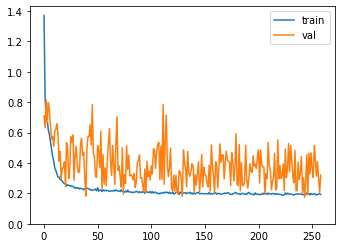

In [19]:
DECODED_LOSS_WEIGHT = 0.0
REQS_LOSS_WEIGHT = 0.0
EYES_LOSS_WEIGHT = 1.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("reqs loss weight", REQS_LOSS_WEIGHT)
mlflow.log_param("eyes loss weight", EYES_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy",
    "output_eyes": eye_localization_fvc
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": REQS_LOSS_WEIGHT,
    "output_eyes": EYES_LOSS_WEIGHT,
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc],
    "output_eyes": ["mae", "mse", eye_localization_accuracy]
}
METRIC_TO_MONITOR = "val_output_eyes_eye_localization_accuracy"
METRIC_MODE = "max"

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode=METRIC_MODE, verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode=METRIC_MODE, patience=50, verbose=1, restore_best_weights=True)
]

affine_params = dict(
    translate_percent=[-0.2, 0.2],
    rotate=[-30, 30],
    scale=[0.8, 1.2],
    order=0,
)

gen_train = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=32, **affine_params)
gen_valid = ImageLandmarkGenerator(x_val, y_val_reqs, y_val_eyes, batch_size=32, **affine_params)

hist = model.fit_generator(
    gen_train,
    steps_per_epoch=100,
    epochs=500,
    validation_data=gen_valid,
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

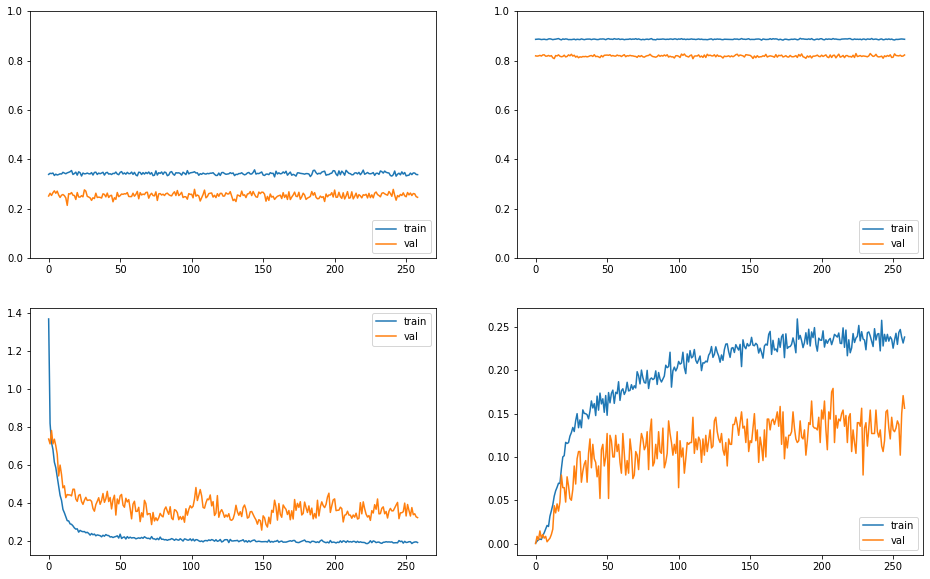

In [20]:
history = hist.history

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history['output_eyes_loss'], label='train')
plt.plot(history['val_output_eyes_loss'], label='val')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.plot(history['output_eyes_eye_localization_accuracy'], label='train')
plt.plot(history['val_output_eyes_eye_localization_accuracy'], label='val')
plt.legend(loc='lower right')

# Test Model

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1]
[[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1]]
[66.  72.  91.  70.5]
[31.297731 46.624813 56.566353 32.08027 ]


Text(0.5, 1.0, 'decoded image')

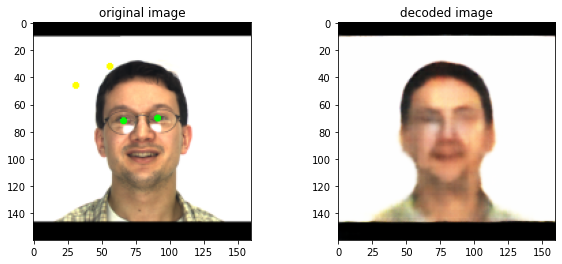

In [36]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true_reqs = y_val_reqs[random_idx]
y_true_eyes = y_val_eyes[random_idx]
y_pred_decoded, y_pred_reqs, y_pred_eyes = model.predict(im / 255)
y_pred_reqs = np.where(y_pred_reqs > 0.5, 1, 0)
y_pred_eyes = (y_pred_eyes * im.shape[1]).flatten()

print(y_true_reqs, y_pred_reqs, sep='\n')
print(y_true_eyes, y_pred_eyes, sep='\n')

im = (im).squeeze()[:, :, ::-1].astype(np.uint8)
true_r = tuple(y_true_eyes[:2].astype(np.int))
true_l = tuple(y_true_eyes[2:].astype(np.int))
pred_r = tuple(y_pred_eyes[:2].astype(np.int))
pred_l = tuple(y_pred_eyes[2:].astype(np.int))
cv2.circle(im, true_r, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, true_l, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, pred_r, radius=1, color=(255, 255, 0), thickness=2)
cv2.circle(im, pred_l, radius=1, color=(255, 255, 0), thickness=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [ ]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(
    inputs=model.inputs,
    outputs=[model.get_layer('outputs').output, model.get_layer('output_eyes').output],
    name="ICAOnet"
)
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

In [ ]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/afwDB_0.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)
y_pred_clf, y_pred_reg = model_clf.predict(im)
assert(np.allclose(y_pred_ori[1], y_pred_clf))
assert(np.allclose(y_pred_ori[2], y_pred_reg))

print("Reqs:")
for y_pred in y_pred_clf[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_reg[0]:
    print(y_pred)

# Embeddings Visualization 

In [ ]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [ ]:
image_files = np.array(dataset.image_files)[x_val_idx]
data = np.array(dataset.images)[x_val_idx]
mrks = np.array(dataset.mrks)[x_val_idx]

image_files = [basename(filepath) for filepath in image_files]
print(len(image_files))
print(data.shape)

In [ ]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [ ]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [ ]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

### Embeddings 

In [ ]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

In [ ]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

### Tensorboard 

In [ ]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [ ]:
mlflow.end_run()